In [ ]:
# In this notebook, we take an English translation of the Bible, embed the verses with sentence-transformers, and use
# a rule-based approach to compute a chiasm score for a sliding window. We then 

In [ ]:
! pip install sentence-transformers -qqq

In [17]:
# load an English bible txt file
import pandas as pd

bible = pd.read_csv("../bibles/eng_ENGESV.api.txt", sep='\t', 
                    header=None, 
                    names=['ref', 'text'],
                    dtype = {'ref': str, 'text': str})
bible['book'] = bible['ref'].apply(lambda x: int(x[:2]))
bible['chapter'] = bible['ref'].apply(lambda x: int(x[2:5]))
bible['verse'] = bible['ref'].apply(lambda x: int(x[-2:]))
bible.head()

,ref,text,book,chapter,verse
0,01001001,"In the beginning, God created the heavens and ...",1,1,1
1,01001002,"The earth was without form and void, and darkn...",1,1,2
2,01001003,"And God said, “Let there be light,” and there ...",1,1,3
3,01001004,And God saw that the light was good. And God s...,1,1,4
4,01001005,"God called the light Day, and the darkness he ...",1,1,5


In [2]:
# get the embeddings model
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('sentence-transformers/LaBSE')

In [1]:
# make a verse-to-verse embeddings matrix
import numpy as np
# embeds = model.encode(bible['text'])

embeds = np.load('bible_embeds.npy')

In [2]:
embeds.shape

(31086, 768)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(embeds,embeds)

In [74]:
cos_sim.shape

(31086, 31086)

In [93]:
def get_chiasm_score(cos_sim, n=4, sim_threshold=0.95):
    # the basic chiasm score is the sum of ther reversed diagonal elements of the cosine similarity matrix
    # then we add a penalty for high similarity scores between different levels. Setting the threshold very high means we're just trying to capture
    # cases where text reuse is very high
    scores = []
    for i in range(0, cos_sim.shape[0]-n+1):
        scores.append(cos_sim[i:i+n, i:i+n][::-1].trace())
        # adding a penalty for high similarity scores between different levels
        for j in range(1,n):
            if cos_sim[i+j, i+n-1-j] > sim_threshold:
                scores[-1] -= cos_sim[i+j, i+n-1-j]
    return scores

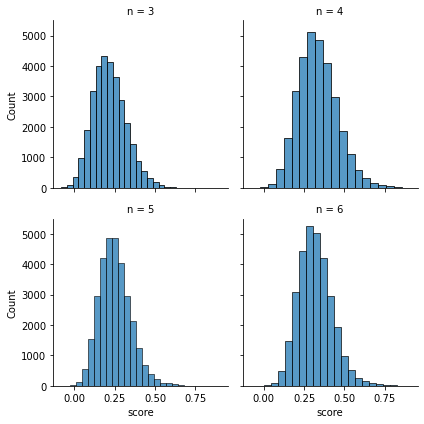

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# a grid plot of the scores for different values of n
n_values = [3,4,5,6]
scores = []
data = pd.DataFrame()
for n in n_values:
    scores.append(get_chiasm_score(cos_sim, n=n))
    # we should probably normalize them, as higher values of n will necessarily have higher average scores
    scores[-1] = [x/n for x in scores[-1]]
    data = pd.concat([data, pd.DataFrame({'score': scores[-1], 'n': n})])

g = sns.FacetGrid(data, col='n', col_wrap=2)
g.map(sns.histplot, 'score', bins=20)
plt.show()

In [98]:
from collections import Counter
def get_top_candidates(source, scores, n=4, k=10):
    top_k = Counter()
    for i, score in enumerate(scores):
        top_k["\n".join(source[i:i+n])] = score
    # sort the Counter by score
    # sorted(top_k.items(), key=lambda x: x[1], reverse=True)
    return top_k.most_common(k)


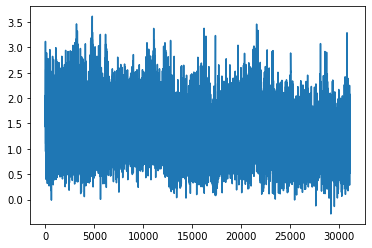

[('And they set out from Makheloth and camped at Tahath.\nAnd they set out from Tahath and camped at Terah.\nAnd they set out from Terah and camped at Mithkah.\nAnd they set out from Mithkah and camped at Hashmonah.',
  3.6161137),
 ('And they set out from Haradah and camped at Makheloth.\nAnd they set out from Makheloth and camped at Tahath.\nAnd they set out from Tahath and camped at Terah.\nAnd they set out from Terah and camped at Mithkah.',
  3.469081),
 ('And they set out from Mount Shepher and camped at Haradah.\nAnd they set out from Haradah and camped at Makheloth.\nAnd they set out from Makheloth and camped at Tahath.\nAnd they set out from Tahath and camped at Terah.',
  3.4676147),
 ('And anyone who touches his bed shall wash his clothes and bathe himself in water and be unclean until the evening.\nAnd whoever sits on anything on which the one with the discharge has sat shall wash his clothes and bathe himself in water and be unclean until the evening.\nAnd whoever touches 

In [99]:
scores = get_chiasm_score(cos_sim, n=4)
# plot the scores
sns.lineplot(x=range(len(scores)), y=scores)
plt.show()
get_top_candidates(bible['text'], scores, n=4, k=10)

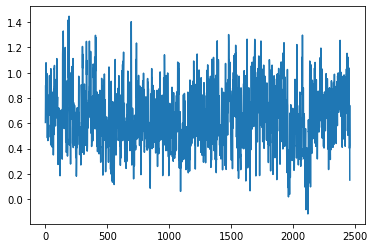

1.4470456
The LORD also thundered in the heavens, and the Most High uttered his voice, hailstones and coals of fire.
And he sent out his arrows and scattered them; he flashed forth lightnings and routed them.
Then the channels of the sea were seen, and the foundations of the world were laid bare at your rebuke, O LORD, at the blast of the breath of your nostrils.
He sent from on high, he took me; he drew me out of many waters.

1.4175296
In my distress I called upon the LORD; to my God I cried for help. From his temple he heard my voice, and my cry to him reached his ears.
Then the earth reeled and rocked; the foundations also of the mountains trembled and quaked, because he was angry.
Smoke went up from his nostrils, and devouring fire from his mouth; glowing coals flamed forth from him.
He bowed the heavens and came down; thick darkness was under his feet.

1.4043359
God reigns over the nations; God sits on his holy throne.
The princes of the peoples gather as the people of the God o

In [97]:
# now if I want to get top cadidates from a specific book, I can just filter the dataframe
# and get the scores for that book
book = 19 # psalms
psalm_scores = get_chiasm_score(cos_sim[bible['book']==book], n=4)
sns.lineplot(x=range(len(psalm_scores)), y=psalm_scores)
plt.show()
candidates = get_top_candidates(bible[bible['book']==book]['text'], psalm_scores, n=4, k=50)
for c, score in candidates:
    print(score)
    print(c)
    print()

In [120]:
! pwd

/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/notebooks


ModuleNotFoundError: No module named '/Users/hope/Documents/10 Projects/14 PhD/14'

In [64]:
# just checking that it's the right book
bible[bible['book']==19][bible['chapter'] == 42]

/Users/hope/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ref,text,book,chapter,verse
14556,19042001,"As a deer pants for flowing streams, so pants ...",19,42,1
14557,19042002,"My soul thirsts for God, for the living God. W...",19,42,2
14558,19042003,"My tears have been my food day and night, whil...",19,42,3
14559,19042004,"These things I remember, as I pour out my soul...",19,42,4
14560,19042005,"Why are you cast down, O my soul, and why are ...",19,42,5
14561,19042006,and my God. My soul is cast down within me; th...,19,42,6
14562,19042007,Deep calls to deep at the roar of your waterfa...,19,42,7
14563,19042008,"By day the LORD commands his steadfast love, a...",19,42,8
14564,19042009,"I say to God, my rock: “Why have you forgotten...",19,42,9
14565,19042010,"As with a deadly wound in my bones, my adversa...",19,42,10
